In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("base-de-datos---enusc-2024-csv.csv")

In [11]:
print(df.columns)
print(df.shape)

Index([';"rph_ID";"idhogar";"enc_idr";"enc_region";"IH_residencia_habitual";"IH_comparte_gastos";"IH_numero_grupos";"IH_cantidad_hogar";"rph_numeroLinea";"rph_numHogar";"rph_parentesco";"rph_edad";"rph_sexo";"Kish";"Hogar_Kish";"rph_idgen";"rph_disc_a";"rph_disc_b";"rph_disc_c";"rph_disc_d";"rph_disc_e";"rph_disc_f";"rph_pertenencia_indigena";"rph_lugar_nacimiento";"rph_migracion";"rph_nacionalidad";"rph_nivel";"rph_estadocivil";"rph_situacion_laboral_a";"rph_situacion_laboral_b";"rph_categoria_ocupacional";"rph_ciuo";"rph_busqueda_empleo";"rph_disponibilidad_trabajar";"rph_razon_inactividad";"rph_nse";"rph_proveedor";"P_AUMENTO_PAIS";"P_AUMENTO_COM";"P_AUMENTO_BARRIO";"P_FUENTE_INFO_PAIS_1";"P_FUENTE_INFO_COM_1";"P_FUENTE_INFO_BARRIO_1";"P_INSEG_LUGARES_1";"P_INSEG_LUGARES_2";"P_INSEG_LUGARES_3";"P_INSEG_LUGARES_4";"P_INSEG_LUGARES_5";"P_INSEG_LUGARES_6";"P_INSEG_LUGARES_7";"P_INSEG_LUGARES_8";"P_INSEG_LUGARES_9";"P_INSEG_LUGARES_10";"P_INSEG_LUGARES_11";"P_INSEG_LUGARES_12";"P_INSEG_

In [19]:
df = pd.read_csv(
    "base-de-datos---enusc-2024-csv.csv",
    sep=";",
    quotechar='"',
    encoding="utf-8-sig",
    engine="python"   # <- mantienes python
    # low_memory=False  # <- QUITAR esta línea
)




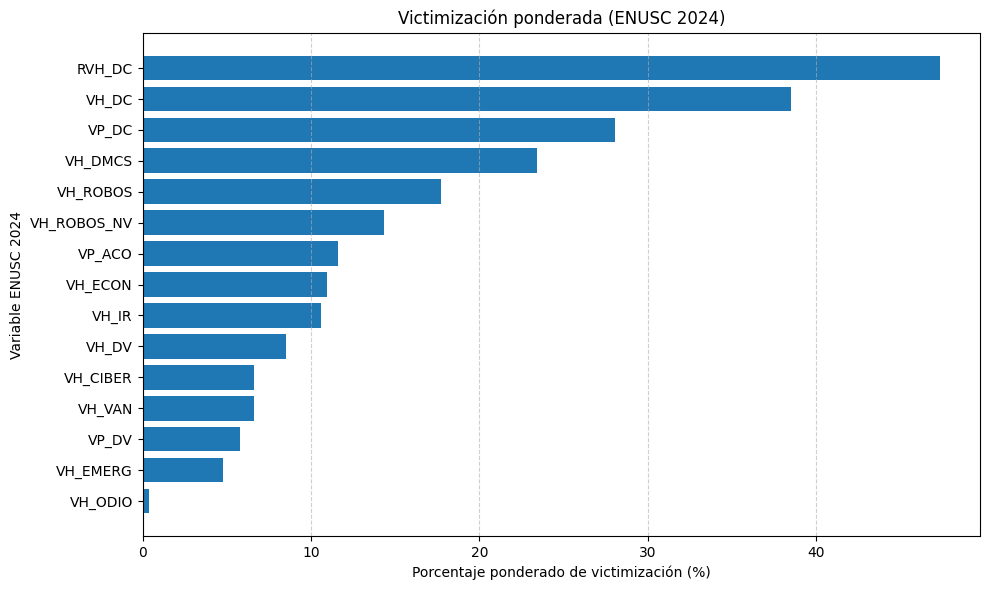

,Variable,Unidad,Ponderador,Victimización (%)
0,RVH_DC,Hogar,Fact_Hog_Reg,47.342918
1,VH_DC,Hogar,Fact_Hog_Reg,38.476001
2,VP_DC,Persona,Fact_Pers_Reg,28.034525
3,VH_DMCS,Hogar,Fact_Hog_Reg,23.440020
4,VH_ROBOS,Hogar,Fact_Hog_Reg,17.701042
5,VH_ROBOS_NV,Hogar,Fact_Hog_Reg,14.325024
6,VP_ACO,Persona,Fact_Pers_Reg,11.614367
7,VH_ECON,Hogar,Fact_Hog_Reg,10.956423
8,VH_IR,Hogar,Fact_Hog_Reg,10.577316
9,VH_DV,Hogar,Fact_Hog_Reg,8.489662


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Helpers ---
def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in df.columns: return cand
        if cand.lower() in cols_lower: return cols_lower[cand.lower()]
    pat = re.compile("|".join([re.escape(c) for c in candidates]), flags=re.I)
    hits = [c for c in df.columns if pat.search(c)]
    return hits[0] if hits else None

def as_numeric(s):
    # fuerza numérico incluso si vino como string con comas
    if np.issubdtype(s.dtype, np.number):
        return s.astype(float)
    s2 = (s.astype(str)
            .str.replace(r"[^\d\-,.]", "", regex=True)  # limpia basura
            .str.replace(".", "", regex=False)          # quita miles con punto
            .str.replace(",", ".", regex=False))        # coma -> punto
    return pd.to_numeric(s2, errors="coerce")

def to_binary_enusc(s):
    # Pone NaN a 77/88/99 y a cualquier cosa distinta de 0/1
    x = pd.to_numeric(s, errors="coerce")
    x = x.where(~x.isin([77, 88, 99]), np.nan)
    x = x.where(x.isin([0, 1]), np.nan)
    return x

def weighted_prop(series, weights):
    x = to_binary_enusc(series)
    w = as_numeric(weights)
    m = x.notna() & w.notna() & (w > 0)
    if not m.any():
        return np.nan
    return np.average(x[m], weights=w[m].astype(float))

# --- Columnas clave (ya cargaste df correctamente con sep=';' etc.) ---
w_person = find_col(df, ["Fact_Pers_Reg","Fact_Pers_Regional_102"])
w_house  = find_col(df, ["Fact_Hog_Reg","Fact_Hog_Regional_102"])

kish_col = find_col(df, ["Kish"])
if kish_col:
    df = df[df[kish_col] == 1]

# Asegura que los ponderadores queden en float
if w_person: df[w_person] = as_numeric(df[w_person])
if w_house:  df[w_house]  = as_numeric(df[w_house])

# --- Variables de victimización (ajústalas si quieres) ---
vict_vars = [v for v in [
    "VH_DC","VP_DC","VH_DV","VP_DV","VH_IR","VH_ODIO","VH_CIBER",
    "VH_VAN","VH_ECON","VH_ROBOS","VH_ROBOS_NV","VH_EMERG",
    "RVH_DC","VH_DMCS","VP_ACO"
] if v in df.columns]

rows = []
for var in vict_vars:
    if var.startswith("VP_"):
        w = df[w_person] if w_person else df[w_house]
        unidad, wname = "Persona", (w_person or w_house)
    else:
        w = df[w_house] if w_house else df[w_person]
        unidad, wname = "Hogar",   (w_house or w_person)

    p = weighted_prop(df[var], w) * 100
    rows.append({"Variable": var, "Unidad": unidad, "Ponderador": wname, "Victimización (%)": p})

vict_stats = (pd.DataFrame(rows)
              .sort_values("Victimización (%)", ascending=False)
              .reset_index(drop=True))

# --- Gráfico ---
plt.figure(figsize=(10,6))
plt.barh(vict_stats["Variable"], vict_stats["Victimización (%)"])
plt.xlabel("Porcentaje ponderado de victimización (%)")
plt.ylabel("Variable ENUSC 2024")
plt.title("Victimización ponderada (ENUSC 2024)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

vict_stats.head(15)




In [23]:
# Diccionario de nombres descriptivos (ajusta según tu cuestionario)
nombre_completo = {
    "RVH_DC": "Robo con violencia o intimidación (Hogar)",
    "VH_DC": "Robo con violencia o intimidación (Hogar)",
    "VP_DC": "Robo con violencia o intimidación (Persona)",
    "VH_DV": "Delitos violentos (Hogar)",
    "VP_DV": "Delitos violentos (Persona)",
    "VH_IR": "Intento de robo (Hogar)",
    "VH_CIBER": "Delito cibernético",
    "VH_VAN": "Vandalismo o daños a la propiedad",
    "VH_ECON": "Delitos económicos",
    "VH_ODIO": "Delitos de odio",
    "VH_DMCS": "Daños materiales con consecuencias sociales",
    "VH_ROBOS": "Robo o hurto general (Hogar)",
    "VH_ROBOS_NV": "Robo no violento (Hogar)",
    "VP_ACO": "Acoso o amenazas (Persona)",
    "VH_EMERG": "Emergencias delictivas",
}


In [24]:
# nueva variable con nombre completo de cada codigo
vict_stats["Nombre completo"] = vict_stats["Variable"].map(nombre_completo)

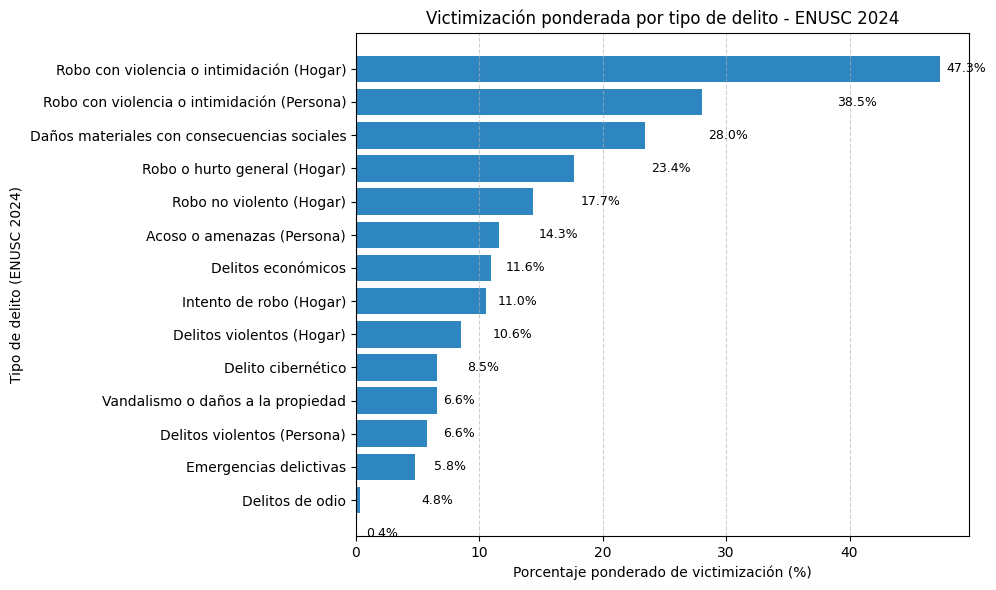

In [25]:
plt.figure(figsize=(10,6))
plt.barh(vict_stats["Nombre completo"], vict_stats["Victimización (%)"], color="#2E86C1")
plt.xlabel("Porcentaje ponderado de victimización (%)")
plt.ylabel("Tipo de delito (ENUSC 2024)")
plt.title("Victimización ponderada por tipo de delito - ENUSC 2024")
plt.gca().invert_yaxis()

# Etiquetas de porcentaje
for i, v in enumerate(vict_stats["Victimización (%)"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=9)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
